In [1]:
import numpy as np
import math as mp
import pandas as pd

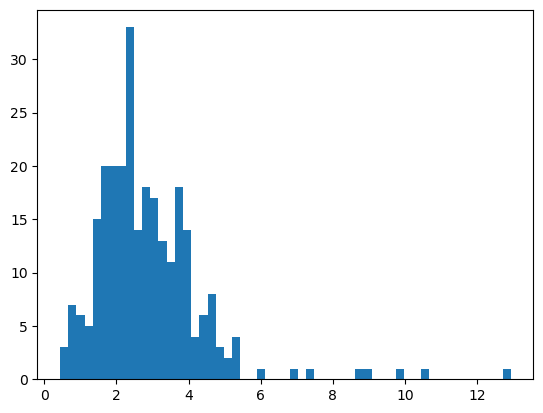

/var/folders/26/bmvk0hrd5xbgcvl_s6s42rf80000gn/T/ipykernel_7920/1959530809.py:13: RuntimeWarning: divide by zero encountered in log
  N = -(data_tau) - 1/np.log(beta*c)
/var/folders/26/bmvk0hrd5xbgcvl_s6s42rf80000gn/T/ipykernel_7920/1959530809.py:14: RuntimeWarning: divide by zero encountered in log
  tau1= -1/np.log(beta*c) - N
/var/folders/26/bmvk0hrd5xbgcvl_s6s42rf80000gn/T/ipykernel_7920/1959530809.py:16: RuntimeWarning: divide by zero encountered in log
  tau2= -1/np.log(beta1*c) - N


In [2]:
sigma = 5
beta = 1 /( 1.0 +0.01)
beta1 =1/( (1.0 +0.01* np.exp(30/(36.5*0.9)))) 
W = 1
data=pd.read_csv('APP_data_usa_goods.csv', index_col=0, parse_dates=True, infer_datetime_format=True)
data_tau=(data['invtCogsRatio']* 36.5/(30*0.1))
import matplotlib.pyplot as plt
plt.hist(data_tau,bins = 55)
plt.show()
tau_diff = np.zeros(( 1000,1))
i = 0
for c in np.linspace(0, 0.99, 1000): 
    N = -(data_tau) - 1/np.log(beta*c) 
    tau1= -1/np.log(beta*c) - N
    tau1[tau1<0] = 0     
    tau2= -1/np.log(beta1*c) - N
    tau2[tau2<0] = 0    
    tau_diff[i] = np.mean(np.abs(tau1-tau2))
    i = i+1

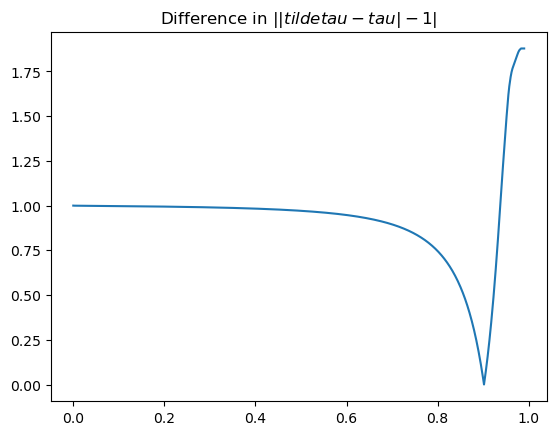

In [3]:
plt.plot(np.linspace(0, 0.99, 1000),np.abs(tau_diff-1))
plt.title('Difference in $||tildetau - tau| -1|$')

plt.show()

In [4]:
min_val = np.min(np.abs(tau_diff-1))
argmins = np.where(np.abs(tau_diff-1) == min_val)[0]
c_list = np.linspace(0, 0.99, 1000)
c=c_list[argmins]
N=-data_tau - 1/np.log(beta*c) 
tau= -1/np.log(beta*c) - N
tau[tau<0] = 0  
tau_floor = np.floor(tau)
tau_ceil = np.ceil(tau)
tprod_ceil=  (beta*c)**tau_ceil * (tau_ceil + N)
tprod_floor=  (beta*c)**tau_floor * (tau_floor + N)

In [5]:
tau[(tprod_ceil-tprod_floor)>0] = tau_ceil[(tprod_ceil-tprod_floor)>0]
tau[(tprod_ceil-tprod_floor)<0] = tau_floor[(tprod_ceil-tprod_floor)<0]
tau[tau<0] = 0  
tprod = (beta*c)**tau * (tau + N)
tau = np.array(tau, dtype=int)

In [6]:
r = 0.01
beta_org = (1 / (1 + 0.01))*c
tau= -1/np.log(beta_org) - N
tau[tau<0] = 0  
tau_floor = np.floor(tau)
tau_ceil = np.ceil(tau)
tprod_ceil=  beta_org**tau_ceil * (tau_ceil + N)
tprod_floor=  beta_org**tau_floor * (tau_floor + N)
tau[(tprod_ceil-tprod_floor)>0] = tau_ceil[(tprod_ceil-tprod_floor)>0]
tau[(tprod_ceil-tprod_floor)<0] = tau_floor[(tprod_ceil-tprod_floor)<0]
tau[tau<0] = 0 
tprod1=  np.array(beta_org**tau * (tau + N) )  
P0 = (np.sum(1/(tprod1)**(1-sigma)))**(1/(1-sigma)) 

beta_rep = (1 / (1 + r))*c
tau_rep= -1/np.log(beta_rep) - 0.99* N
tau_rep[tau_rep<0] = 0  
tau_rep_floor = np.floor(tau_rep)
tau_rep_ceil = np.ceil(tau_rep)
tprod_ceil=  beta_rep**tau_rep_ceil * (tau_rep_ceil + 0.99*N)
tprod_floor=  beta_rep**tau_rep_floor * (tau_rep_floor + 0.99* N)
tau_rep[(tprod_ceil-tprod_floor)>0] = tau_rep_ceil[(tprod_ceil-tprod_floor)>0]
tau_rep[(tprod_ceil-tprod_floor)<0] = tau_rep_floor[(tprod_ceil-tprod_floor)<0]
tau_rep[tau_rep<0] = 0 
tprod_rep=  np.array(beta_rep**tau_rep * (tau_rep +  N) )  
Pend = (np.sum(1/(tprod_rep)**(1-sigma)))**(1/(1-sigma)) 

P = np.zeros((int(np.max(tau_rep))+2, 1))
P[0, 0] = P0
P[-1, 0] = P0


tau = tau.sort_values()
tau_rep = tau_rep.sort_values()
diff = tau-tau_rep
index_diff=tau_rep[diff !=0].index

In [7]:
index_diff

Int64Index([221310, 327993, 323117, 327320, 336415, 327420, 325613, 325520,
            325211, 332420, 337215, 334112, 325510, 322212, 316210, 339114],
           dtype='int64', name='naics6')

In [8]:
tau_list = {}
tau_list[0] = np.array(tau)

for j in range(0, int(np.max(tau_rep)) + 1):
    tau1_temp = pd.Series(tau[tau > j])
    tau2_temp = pd.Series(tau_rep[tau_rep <= j])

    tau1_temp_df = tau1_temp.to_frame(name='t')
    tau1_temp_df['source'] = 'org'

    tau2_temp_df = tau2_temp.to_frame(name='t')
    tau2_temp_df['source'] = 'rep'

    t_temp = pd.concat([tau1_temp_df, tau2_temp_df])

    dup_indices = t_temp.index[t_temp.index.duplicated(keep=False)].unique()

    keep_rows = []

    for i in dup_indices:
        rows = t_temp.loc[[i]]
        N_temp = N.loc[[i]]
        t_org = rows[rows['source'] == 'org']['t'].values[0]
        t_rep = rows[rows['source'] == 'rep']['t'].values[0]

        tprod_org_temp = beta_org**t_org * (t_org + N_temp)
        tprod_rep_temp = beta_rep**t_rep * (t_rep + N_temp)
        if i ==j:
            tprod_rep_temp = beta_rep**t_rep * (t_rep +0.99* N_temp)

        # Keep only the row with the higher value
        if tprod_org_temp.values >= tprod_rep_temp.values:
            keep_rows.append(rows[rows['source'] == 'org'])
        else:
            keep_rows.append(rows[rows['source'] == 'rep'])

    # Drop all duplicates first
    t_temp = t_temp[~t_temp.index.isin(dup_indices)]

    # Add back only the best ones
    if keep_rows:
        t_temp = pd.concat([t_temp] + keep_rows)
    t_temp['N'] = N.loc[t_temp.index].values

    # Step 1: Add matching N values
    t_temp['N'] = N.loc[t_temp.index].values  # will align correctly by NAICS6 index

    # Step 2: Compute t_prod using vectorized logic
    beta_vec = t_temp['source'].map({'org': beta_org, 'rep': beta_rep})
    A_vec = np.where((t_temp['source'] == 'rep') & (t_temp['t'] == j), 0.99, 1.0)
    t_temp['A'] = A_vec
    t_temp['t_prod'] = beta_vec ** t_temp['t'] * (t_temp['t'] +A_vec *  t_temp['N'])
    
    tprod_temp = t_temp['t_prod'].values



# Compute P[j+1, 0]
    P[j + 1, 0] = (np.sum(1 / (tprod_temp ** (1 - sigma)))) ** (1 / (1 - sigma))
Ps = P

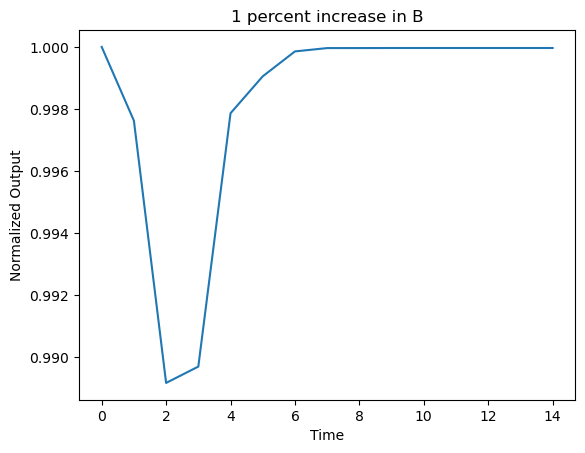

In [9]:
import matplotlib.pyplot as plt

plt.plot( (1/ P)* P[0])
plt.title('1 percent increase in B')
plt.xlabel('Time')
plt.ylabel('Normalized Output') 
plt.show()

In [10]:
r_arrange = np.linspace(0, 0.05, 100)
P = np.zeros((20, 100))
k=0
shock = 0.99
tau_list = {}
index_diff_list = {}
for r in r_arrange: 
    beta_org = (1 / (1 + 0.01))*c
    tau= -1/np.log(beta_org) - N
    tau[tau<0] = 0  
    tau_floor = np.floor(tau)
    tau_ceil = np.ceil(tau)
    tprod_ceil=  beta_org**tau_ceil * (tau_ceil + N)
    tprod_floor=  beta_org**tau_floor * (tau_floor + N)
    tau[(tprod_ceil-tprod_floor)>0] = tau_ceil[(tprod_ceil-tprod_floor)>0]
    tau[(tprod_ceil-tprod_floor)<0] = tau_floor[(tprod_ceil-tprod_floor)<0]
    tau[tau<0] = 0 
    tprod1=  np.array(beta_org**tau * (tau + N) )  
    P0 = (np.sum(1/(tprod1)**(1-sigma)))**(1/(1-sigma)) 

    beta_rep = (1 / (1 + r))*c
    tau_rep= -1/np.log(beta_rep) - shock*N
    tau_rep[tau_rep<0] = 0  
    tau_rep_floor = np.floor(tau_rep)
    tau_rep_ceil = np.ceil(tau_rep)
    tprod_ceil=  beta_rep**tau_rep_ceil * (tau_rep_ceil +  shock*N)
    tprod_floor=  beta_rep**tau_rep_floor * (tau_rep_floor +  shock*N)
    tau_rep[(tprod_ceil-tprod_floor)>0] = tau_rep_ceil[(tprod_ceil-tprod_floor)>0]
    tau_rep[(tprod_ceil-tprod_floor)<0] = tau_rep_floor[(tprod_ceil-tprod_floor)<0]
    tau_rep[tau_rep<0] = 0 

    P[0, k] = P0

    tau = tau.sort_values()
    tau_rep = tau_rep.sort_values()
    tau_list[k] = np.array(tau_rep)
    diff = tau-tau_rep
    index_diff=tau_rep[diff !=0].index
    index_diff_list[k] = np.sum(index_diff!=0)

    for j in range(0, int(np.max(tau_rep)) + 1):
        tau1_temp = pd.Series(tau[tau > j])
        tau2_temp = pd.Series(tau_rep[tau_rep <= j])

        tau1_temp_df = tau1_temp.to_frame(name='t')
        tau1_temp_df['source'] = 'org'

        tau2_temp_df = tau2_temp.to_frame(name='t')
        tau2_temp_df['source'] = 'rep'

        t_temp = pd.concat([tau1_temp_df, tau2_temp_df])

        dup_indices = t_temp.index[t_temp.index.duplicated(keep=False)].unique()

        keep_rows = []

        for i in dup_indices:
            rows = t_temp.loc[[i]]
            N_temp = N.loc[[i]]
            t_org = rows[rows['source'] == 'org']['t'].values[0]
            t_rep = rows[rows['source'] == 'rep']['t'].values[0]

            tprod_org_temp = beta_org**t_org * (t_org + N_temp)
            tprod_rep_temp = beta_rep**t_rep * (t_rep + N_temp)
            if i == j:
                tprod_rep_temp = beta_rep**t_rep * (t_rep +  shock* N_temp)

            # Keep only the row with the higher value
            if tprod_org_temp.values >= tprod_rep_temp.values:
                keep_rows.append(rows[rows['source'] == 'org'])
            else:
                keep_rows.append(rows[rows['source'] == 'rep'])

        # Drop all duplicates first
        t_temp = t_temp[~t_temp.index.isin(dup_indices)]

        # Add back only the best ones
        if keep_rows:
            t_temp = pd.concat([t_temp] + keep_rows)
        t_temp['N'] = N.loc[t_temp.index].values

        # Step 1: Add matching N values
        t_temp['N'] = N.loc[t_temp.index].values  # will align correctly by NAICS6 index

        # Step 2: Compute t_prod using vectorized logic
        beta_vec = t_temp['source'].map({'org': beta_org, 'rep': beta_rep})
        A_vec = np.where((t_temp['source'] == 'rep') & (t_temp['t'] == j), shock, 1.0)
        t_temp['A'] = A_vec
        t_temp['t_prod'] =  beta_vec ** t_temp['t'] * (t_temp['t'] + A_vec*t_temp['N'])
        
        tprod_temp = t_temp['t_prod'].values
        P[j + 1, k] = (np.sum(1 / (tprod_temp ** (1 - sigma)))) ** (1 / (1 - sigma))


    tau_rep= -1/np.log(beta_rep) - N
    tau_rep[tau_rep<0] = 0  
    tau_rep_floor = np.floor(tau_rep)
    tau_rep_ceil = np.ceil(tau_rep)
    tprod_ceil=  beta_rep**tau_rep_ceil * (tau_rep_ceil +  N)
    tprod_floor=  beta_rep**tau_rep_floor * (tau_rep_floor +  N)
    tau_rep[(tprod_ceil-tprod_floor)>0] = tau_rep_ceil[(tprod_ceil-tprod_floor)>0]
    tau_rep[(tprod_ceil-tprod_floor)<0] = tau_rep_floor[(tprod_ceil-tprod_floor)<0]
    tau_rep[tau_rep<0] = 0 
    tprod_rep=  np.array(beta_rep**tau_rep * (tau_rep +  N) )  
    P1 = (np.sum(1/(tprod_rep)**(1-sigma)))**(1/(1-sigma)) 
    P[j+1, k] = P1

    k = k+1
    print(k)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [11]:
k=0
deviation_gap = np.zeros((100, 1))
for r in r_arrange: 
    P_temp = P[:,k]
    P_temp_no_zeros = P_temp[P_temp != 0]
    Y = np.zeros((len(P_temp_no_zeros), 1))
    Y[0] = 1/P_temp_no_zeros[0] *P_temp_no_zeros[0]
    Y[1:,0] = 1/P_temp_no_zeros[1:] *P_temp_no_zeros[-1]
    deviation_gap[k] = np.sum((Y - 1 )**2) 
    k = k+1

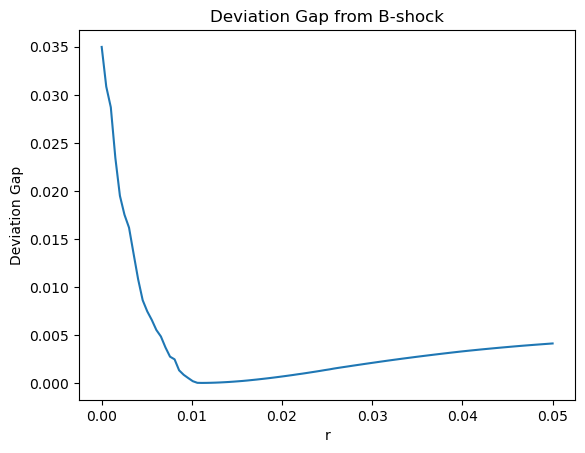

In [12]:
plt.plot(r_arrange,deviation_gap)
plt.title('Deviation Gap from B-shock')
plt.xlabel('r')
plt.ylabel('Deviation Gap')

plt.show()

In [13]:
argmins_gap = np.where(deviation_gap == np.min(deviation_gap))[0]
r_arrange[argmins_gap]

array([0.01111111])

In [14]:
P_temp_adj = P[:,argmins_gap]
P_temp_no_zeros_adj = P_temp_adj[P_temp_adj != 0]
Y_adj = np.zeros((len(P_temp_no_zeros_adj), 1))
Y_adj[0] = 1/P_temp_no_zeros_adj[0] *P_temp_no_zeros_adj[0]
Y_adj[1:,0] = 1/P_temp_no_zeros_adj[1:] *P_temp_no_zeros_adj[-1]

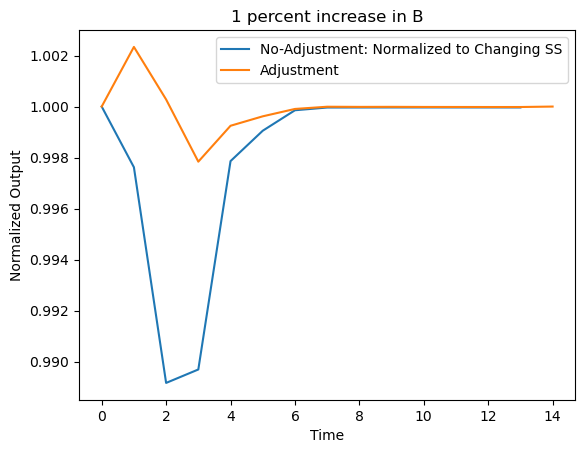

In [16]:
plt.plot( (1/Ps[:-1])*Ps[0])
plt.plot(Y_adj)
plt.title('1 percent increase in B')
plt.xlabel('Time')
plt.ylabel('Normalized Output') 
plt.legend(['No-Adjustment: Normalized to Changing SS', 'Adjustment'])

plt.show()

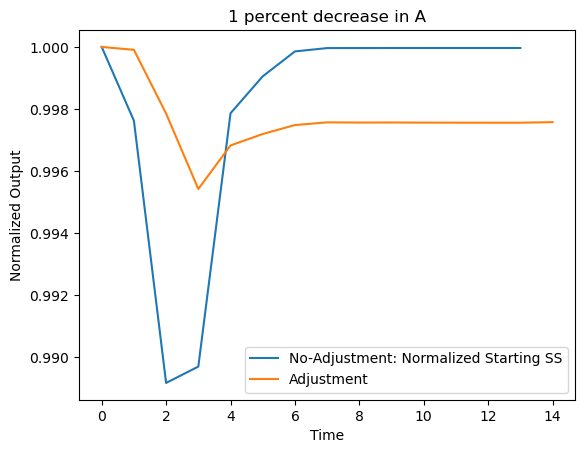

In [ ]:
plt.plot( (1/Ps[:-1])*Ps[0])
plt.plot(1/P_temp_no_zeros_adj*P_temp_no_zeros_adj[0])
plt.title('1 percent increase in B')
plt.xlabel('Time')
plt.ylabel('Normalized Output') 
plt.legend(['No-Adjustment: Normalized Starting SS', 'Adjustment'])

plt.show()

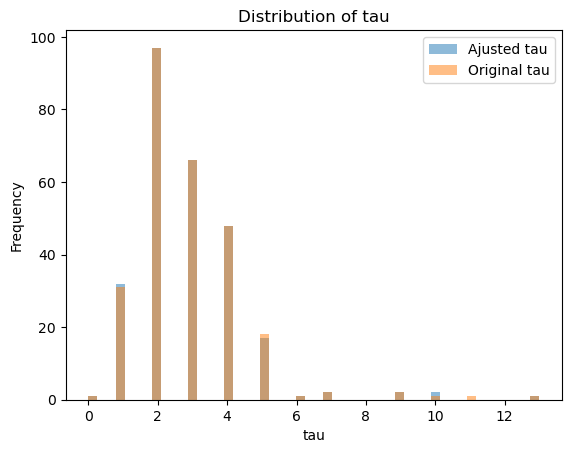

In [18]:
plt.hist(tau_list[argmins_gap[0]], alpha=0.5, bins=50, label='Ajusted tau')
plt.hist(tau, bins=50, alpha=0.5, label='Original tau')
plt.title('Distribution of tau')
plt.xlabel('tau')
plt.ylabel('Frequency')
plt.legend()    
plt.show()

In [50]:
beta_rep = (1 / (1 + 0.01))*c
tau_rep= -1/np.log(beta_rep) - shock*N
tau_rep[tau_rep<0] = 0  
tau_rep_floor = np.floor(tau_rep)
tau_rep_ceil = np.ceil(tau_rep)
tprod_ceil=  beta_rep**tau_rep_ceil * (tau_rep_ceil +  shock*N)
tprod_floor=  beta_rep**tau_rep_floor * (tau_rep_floor +  shock*N)
tau_rep[(tprod_ceil-tprod_floor)>0] = tau_rep_ceil[(tprod_ceil-tprod_floor)>0]
tau_rep[(tprod_ceil-tprod_floor)<0] = tau_rep_floor[(tprod_ceil-tprod_floor)<0]
tau_rep[tau_rep<0] = 0 

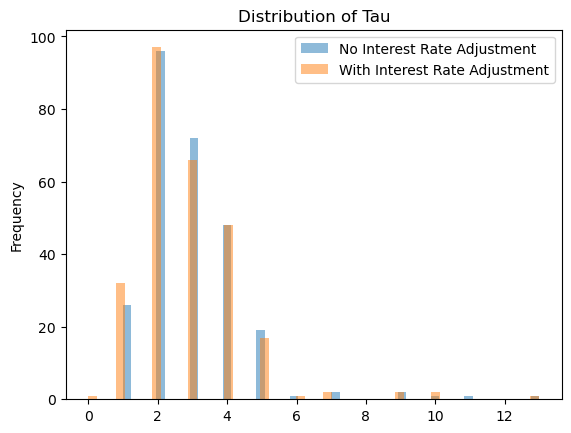

In [51]:
plt.hist(tau_rep, alpha=0.5, bins=50, label='No Interest Rate Adjustment')
plt.hist(tau_list[argmins_gap[0]], alpha=0.5, bins=50, label='With Interest Rate Adjustment')
plt.title('Distribution of Tau')
plt.ylabel('Frequency')
plt.legend()
plt.show()